# Classification using importance-weighted SGPR

This notebook explains how to use Markovflow to build and optimise a GP classifier (in 1D of
course!) using importance-weighted variational inference.

In [1]:
import numpy as np
import tensorflow as tf
from gpflow.ci_utils import ci_niter
from gpflow.likelihoods import Bernoulli

from markovflow.models.iwvi import ImportanceWeightedVI
from markovflow.kernels import Matern32

import matplotlib.pyplot as plt

2022-07-26 11:51:30.080003: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.13/x64/lib
2022-07-26 11:51:30.080036: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Setup
learning_rate = 1e-3
importance_K = 10

# toy data
num_data = 100
time_points = np.linspace(0, 10, num_data).reshape(-1,)
observations = np.cos(2*np.pi * time_points / 3.).reshape(-1, 1) + np.random.randn(num_data, 1) * .8
observations = (observations > 0).astype(float)
data = (tf.convert_to_tensor(time_points), tf.convert_to_tensor(observations))

2022-07-26 11:51:31.699459: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-26 11:51:31.699632: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.13/x64/lib
2022-07-26 11:51:31.699644: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-26 11:51:31.699661: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az99-674): /proc/driver/nvidia/version does not exist
2022-07-26 11:51:31.699906: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FM

In [3]:
# model setup
num_inducing = 20
inducing_points = np.linspace(-1, 11, num_inducing).reshape(-1,)
kernel = Matern32(lengthscale=2.0, variance=4.0)
likelihood = Bernoulli()
m = ImportanceWeightedVI(kernel=kernel,
                         inducing_points=tf.constant(inducing_points, dtype=tf.float64),
                         likelihood=likelihood,
                         num_importance_samples=importance_K)

In [4]:
# optimizer setup
variational_variables = m.dist_q.trainable_variables
hyperparam_variables = m.kernel.trainable_variables
adam_variational = tf.optimizers.Adam(learning_rate)
adam_hyper = tf.optimizers.Adam(learning_rate)

_dregs = lambda: -m.dregs_objective(data)
_iwvi_elbo = lambda: -m.elbo(data)

@tf.function
def step():
    adam_variational.minimize(_dregs, var_list=variational_variables)
    adam_hyper.minimize(_iwvi_elbo, var_list=hyperparam_variables)

@tf.function
def elbo_eval():
    return m.elbo(data)

2022-07-26 11:51:31.761364: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [5]:
# a function to plot the data and model fit

def plot(model):

    time_grid = np.linspace(0, 10, 200).reshape(-1,)

    num_samples = 50
    samples_q_s = model.posterior.proposal_process.sample_state(time_grid, num_samples)
    samples_iwvi = model.posterior.sample_f(time_grid, num_samples, input_data=data)

    _, axarr = plt.subplots(2, 1, sharex=True, sharey=True)
    # plot data
    axarr[0].plot(time_points, observations, 'kx')
    axarr[0].set_title('proposal')
    axarr[0].plot(time_grid, samples_q_s[..., 0].numpy().T, alpha=.1, color='red')

    axarr[1].plot(time_points, observations, 'kx')
    axarr[1].set_title('importance-weighted')
    axarr[1].plot(time_grid, samples_iwvi[..., 0].numpy().T, alpha=.1, color='blue')
    axarr[1].set_ylim(-1.5, 2.5)

    # plot mean by numerically integrating the iwvi posterior
    eps = 1e-3
    inv_link = lambda x : eps + (1-eps) * likelihood.invlink(x)
    probs = m.posterior.expected_value(time_grid, data, inv_link)
    axarr[1].plot(time_grid, probs, color='black', lw=1.6)

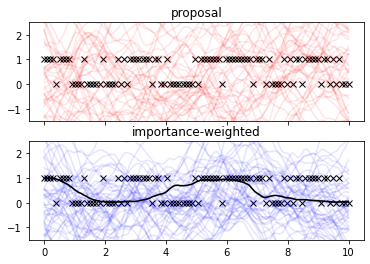

In [6]:
plot(m)

In [7]:
# the optimisation loop
elbos, elbo_stds = [], []
max_iter = ci_niter(2000)
for i in range(max_iter):
    step()
    if i % 10 == 0:
        elbos_i = [elbo_eval().numpy() for _ in range(10)]
        elbos.append(np.mean(elbos_i))
        elbo_stds.append(np.std(elbos_i))
        print(i, elbos[-1], elbo_stds[-1])

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.


Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.


2022-07-26 11:51:44.855637: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-26 11:51:44.948591: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2793435000 Hz


2022-07-26 11:51:46.078330: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:906] Skipping loop optimization for Merge node with control input: assert_equal_29/Assert/AssertGuard/branch_executed/_39


2022-07-26 11:51:50.691480: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:906] Skipping loop optimization for Merge node with control input: assert_equal_29/Assert/AssertGuard/branch_executed/_74


0 -99.91737943682031 15.401378461909665
10 -101.42019228252062 16.05732565371859
20 -92.61211828277348 17.040710035871733
30 -86.60888697644108 7.4473656931012195


40 -101.66093121495027 10.086530961294761
50 -97.98075049818365 9.133036476493352
60 -90.58967167674726 8.379001361850815
70 -99.0884884524377 21.018717274569273


80 -92.39045194827814 10.430362875518538
90 -92.95101075390588 7.251563932493512
100 -90.17719650014122 14.767933478539284
110 -90.97862848184475 8.478895546530406


120 -89.93158357753599 11.681679594449676
130 -102.84636263636625 12.23883833323114
140 -91.62320829358134 12.354111524293778
150 

-89.73990873568545 11.501845965802225
160 -85.76778317728204 13.298791538137433
170 -84.88866759105 7.973615913077716
180 -89.2497841468654 10.712685142198934


190 -88.15356831272481 6.6875530562879755
200 -86.57018400216602 8.556208324752726
210 -86.8318299906016 11.578701457228837
220 -86.99665022421071 13.374291026632783


230 -79.33935699333107 6.222126601895142
240 -84.06660535218737 7.770296191847304
250 -86.15762755764703 7.343099805513134
260 -85.42600675052896 11.302784940113277


270 -85.32282953128866 8.21128662846148
280 -87.07879136704531 8.3694973201408
290 -77.3089035940666 5.202396250463785
300 -80.3045094180637 6.5068709098387645


310 -84.59736437949415 7.145041802589309
320 -82.82805165193352 8.703661045888445
330 -83.78869451254107 10.324419258801209
340 -79.98585729562254 8.023329880386862


350 -79.29215522458055 7.236770154372143
360 -80.71023071468834 6.845500483837575
370 -78.43914442103929 4.550636782310533
380 -79.26615860945915 5.132936624031524


390 -77.43696617431254 6.552827391372196
400 -76.6543581467203 8.319148535051035
410 -82.7697530732508 10.292593668887177
420 -86.38216738223112 5.40889684492249


430 -79.8738867680524 6.539333713477745
440 -74.61502044053933 5.432722844385123
450 -78.90901028640204 2.90001538961449


460 -78.22396047052565 7.713941609120142
470 -79.68241329474111 4.185419009022526
480 -82.19958941222919 4.588304825371417
490 -76.95939942343364 7.178338950890135


500 -75.43046819209246 8.328209929337334
510 -78.47284535642146 7.418259436824641
520 -79.5801208257399 5.124464518817879
530 -78.25838621047949 7.188929331053571


540 -75.79145328705869 5.239273835404192
550 -76.33360313694226 4.322825562470911
560 -78.85916999852415 4.81929386408123
570 -72.33975987583383 5.756786361485765


580 -78.84578211975698 4.838092301307511
590 -76.86271784753168 7.12629590072914
600 -74.1462157946259 6.77743540735163
610 -76.4769392625303 5.253830986727458


620 -72.32790409371009 3.4146737684638566
630 -72.17528113642571 4.693148159938552
640 -74.71657801211492 4.984357206192261
650 -77.48642918619213 6.123665964370401


660 -78.44816967171451 4.701234369157109
670 -74.49834185944329 4.4244723121348875
680 -72.03114931649958 4.633662421115325
690 -73.34416233834881 4.066286498957364


700 -72.84323752982695 5.609358289541097
710 -73.09088090070439 5.396634844169254
720 -73.47704027327514 6.09940795250702
730 -72.66727533802717 6.1490347714080835


740 -74.86764140859341 5.6364722351186645
750 -74.06523127837917 5.735816551274647
760 -72.34468963967956 4.583329564062935
770 -71.45158822552683 5.150061787957688


780 -73.18659978008982 4.351451434241345
790 -73.45145373211847 3.8515567840489435
800 -72.97747846340133 4.800687637570241
810 -72.15980264380416 4.213327467809783


820 -71.172952615454 2.45790301572008
830 -72.354048077061 3.7551666696862642
840 -70.42620545607119 3.4928541136558615
850 -72.51512460237839 4.185797687682078


860 -71.5904250209198 3.7969055347552074
870 -72.08603716319682 5.386726134637081
880 -74.76050789752452 3.567592177141159
890 -73.31032349501808 2.805469759649998


900 -72.40794917741192 4.775835221079268
910 -70.55634517643111 2.368074934350178
920 -72.90459034642097 2.7934484506710784
930 -73.32873522585314 4.667815937550308


940 -70.21107959499446 2.8383600946815095
950 -71.29119222127441 2.7200685313590216
960 -71.27267686403675 6.392050408315929
970 -69.81935009476406 3.595062519931193


980 -69.08206583213075 3.9355769550818454
990 -69.85361478387085 3.0579317967483455
1000 -71.36197766002859 3.702561428123121
1010 -70.15023527531929 3.221091325883156


1020 -70.65934611251785 1.9014442944049321
1030 -69.94079719750343 2.4150326496531647
1040 -70.27293706251803 4.948187844806839
1050 -69.35999596922258 2.4222716092605356


1060 -70.941482948464 2.606336113188865
1070 -71.66802197973227 3.466340102546271
1080 -71.85598444152654 3.165787368752253
1090 -68.9596535045387 2.9988454569543026


1100 -69.89035364261335 2.951549355201146
1110 -70.27391967086105 3.423545910198135
1120 -69.89394498604612 3.7052600985516384
1130 -73.54634954884025 3.08467074019584


1140 -71.26151733431091 2.3730655803693153
1150 -70.56527144021825 2.6902197859284835
1160 -68.29939589304963 2.9388450957109455
1170 -69.96759987243414 3.9658219569521975


1180 -70.6218482708725 3.0517898780364145
1190 -69.41562476441041 3.025340798020096
1200 -69.6605085488021 3.529583869668344
1210 -68.49518483321665 1.8425737046854072


1220 -69.40735612045576 2.7144783513318465
1230 -70.7366249436457 4.491380294488829
1240 -67.92580617179395 1.2542613722905303
1250 -68.43555697168107 0.9195486189250371


1260 -69.51145631691526 2.7665211939189
1270 -69.44963666459232 2.6333343542384746
1280 -67.76964080984834 2.1589099400417204
1290 -69.33331051517152 3.2258190727918294


1300 -68.49884320029281 2.8506284665691233
1310 -69.08940808281776 2.9214651177470494
1320 -69.23868013075601 2.9049958384228525
1330 -68.61072527371124 2.8731714694440433


1340 -70.95103192276942 3.502325791922351
1350 -68.57781879527894 3.049334628213472
1360 -70.22520093387587 2.811664177294495
1370 -69.11540553259809 1.7490676051247203


1380 -68.27963650508536 1.8793499853746938
1390 -69.74159722576022 4.343077203941456
1400 -69.01928020663131 3.335914517835724
1410 -70.94153690681692 3.5481685296436063


1420 -69.18147702987866 2.7989384470357828
1430 -67.66863332816561 1.9316896630669005
1440 -69.80628051651397 2.1311100660874462
1450 -69.71330523749216 2.0685623335168652


1460 -69.08658490448309 2.5060272017098084
1470 -68.42877904168172 2.5476423863917645
1480 -67.72116799061753 2.747478952593789
1490 -68.33783180254795 1.778945023349329


1500 -68.99567034413352 2.002716601501329
1510 -69.26392931331421 2.8530259432568705
1520 -68.3779864631443 3.3168125693607
1530 -67.81560551564864 2.281856129446166


1540 -67.83686937693334 1.1286251006600996
1550 -67.81319782579081 3.2358385610292975
1560 -68.83410538243501 1.8229627582665797
1570 -67.82142391047593 2.917769848638225


1580 -69.42647176162356 2.2633103574474904
1590 -67.13040684238831 1.5752182941177126
1600 -67.84170411381885 2.4487706951656376
1610 -68.53743379748298 2.310468719362275


1620 -68.29041185001418 2.1465627321214455
1630 -69.0875364805037 2.331868839294301
1640 -69.17207846414894 2.7007468230909795
1650 -68.05662868722129 1.9290477552216858


1660 -67.27669700775101 2.1945619951461963
1670 -67.74072356896764 1.6358076342470695
1680 -68.1585106836642 2.152718864077578


1690 -67.54090523120826 1.716415398852291
1700 -69.25140060049534 3.679101878475887
1710 -67.34482492644833 2.2804272325103034


1720 -67.09500062974021 0.977188160271774
1730 -68.03971562422814 1.5016661605278554
1740 -68.46716652358636 2.052045064741496


1750 -67.3340679196061 1.6239387420171014
1760 -68.39204845729101 1.8887831849212104
1770 -67.50156574174044 1.5029581982370737


1780 -67.0159337429176 1.6747813734946202
1790 -68.23932079266814 2.070708178048676
1800 -68.18990480504064 1.9543638430602188


1810 -66.09999750645815 1.3771723064000054
1820 -67.73294461448714 1.6104891544061564
1830 -67.62930367079825 2.1847352368649458


1840 -68.49149355507444 1.9492774377945457
1850 -68.05524894341067 2.235652527493979
1860 -67.25298512064691 1.769891319182499


1870 -67.07104523543669 1.9095667668131693
1880 -67.42930998827391 1.6733938055122162
1890 -66.80901845569554 1.4513282470710307
1900 -67.48203276814063 2.30788997570211


1910 -67.08842419100523 2.0268547527314107
1920 -67.93152375902602 3.1378593364048726
1930 -66.51911310905703 1.3319174972261558
1940 -66.76699533740683 1.4355821961368276


1950 -66.8236015309436 1.1952081776616326
1960 -66.1391663410407 1.5491104234955877
1970 -68.0334758312575 1.0734199805082119
1980 -67.05920686497879 2.103918848838581


1990 -68.24494478649173 2.661846425154831


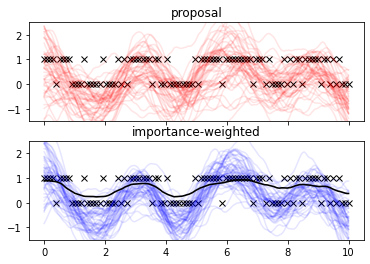

In [8]:
plot(m)